# Lagged cross-covariance analysis

Resolution: 30-degree latitudinal bands, weekly

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [3]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [4]:
# Cut datasets to latitudinal bands and resample to weekly averages within each band
df_sif_weekly = (
    utils.regrid(DS_sif, res=30)
    .groupby(["lat"])
    .resample("1W")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_weekly = (
    utils.regrid(DS_xco2, res=30)
    .groupby(["lat"])
    .resample("1W")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid_weekly = pd.merge(df_sif_weekly, df_xco2_weekly, on=["lat", "time"], how="outer")
df_grid_weekly

,lat,time,sif,xco2
0,-75.0,2014-09-21,0.000471,NaN
1,-75.0,2014-09-28,-0.015148,NaN
2,-75.0,2014-10-05,0.013484,NaN
3,-75.0,2014-10-12,-0.041758,NaN
4,-75.0,2014-10-19,-0.030123,NaN
...,...,...,...,...
1828,75.0,2020-07-05,0.223578,409.213623
1829,75.0,2020-07-12,0.231556,408.681122
1830,75.0,2020-07-19,0.213841,407.477112
1831,75.0,2020-07-26,0.226938,406.948273


In [5]:
# Convert to dataset and compute statistics
DS_grid_weekly = stats.get_stats(
    df_grid_weekly
    .set_index(["lat", "time"])
    .to_xarray()
    .expand_dims(
        dim={"lon": np.arange(-165, 165+30, 30)}, 
        axis=0
    )
)

DS_grid_weekly["xcor_lag1"] = stats.apply_xcor(DS_grid_weekly.xco2, DS_grid_weekly.sif, lag=4, tau=30)
DS_grid_weekly["xcor_lag2"] = stats.apply_xcor(DS_grid_weekly.xco2, DS_grid_weekly.sif, lag=8, tau=30)

DS_grid_weekly

<xarray.Dataset>
Dimensions:     (lat: 6, lon: 12, time: 309)
Coordinates:
  * lon         (lon) int64 -165 -135 -105 -75 -45 -15 15 45 75 105 135 165
  * lat         (lat) float64 -75.0 -45.0 -15.0 15.0 45.0 75.0
  * time        (time) datetime64[ns] 2014-09-07 2014-09-14 ... 2020-08-02
Data variables:
    sif         (lon, lat, time) float32 nan nan ... 0.22693771 0.1945094
    xco2        (lon, lat, time) float32 nan nan nan ... 406.94827 406.23575
    sif_count   (lon, lat) int64 162 301 301 301 301 196 ... 301 301 301 301 196
    xco2_count  (lon, lat) int64 95 300 301 301 301 201 ... 300 301 301 301 201
    sif_slope   (lon, lat) float64 -2.244e-05 -0.0001017 ... 0.0001524 0.0001042
    xco2_slope  (lon, lat) float64 0.04788 0.04801 0.04778 ... 0.04997 0.0509
    sif_std     (lon, lat) float64 0.03718 0.03794 0.06042 ... 0.1164 0.07138
    xco2_std    (lon, lat) float64 1.529 0.4428 0.6186 ... 1.876 2.325 3.698
    xcor_lag1   (lon, lat) float64 -0.004968 -0.246 -0.6984 ... -0.7839 -0.7256
    xcor_lag2   (lon, lat) float64 0.03098 -0.2617 -0.4855 ... -0.8876 -0.4284

/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))


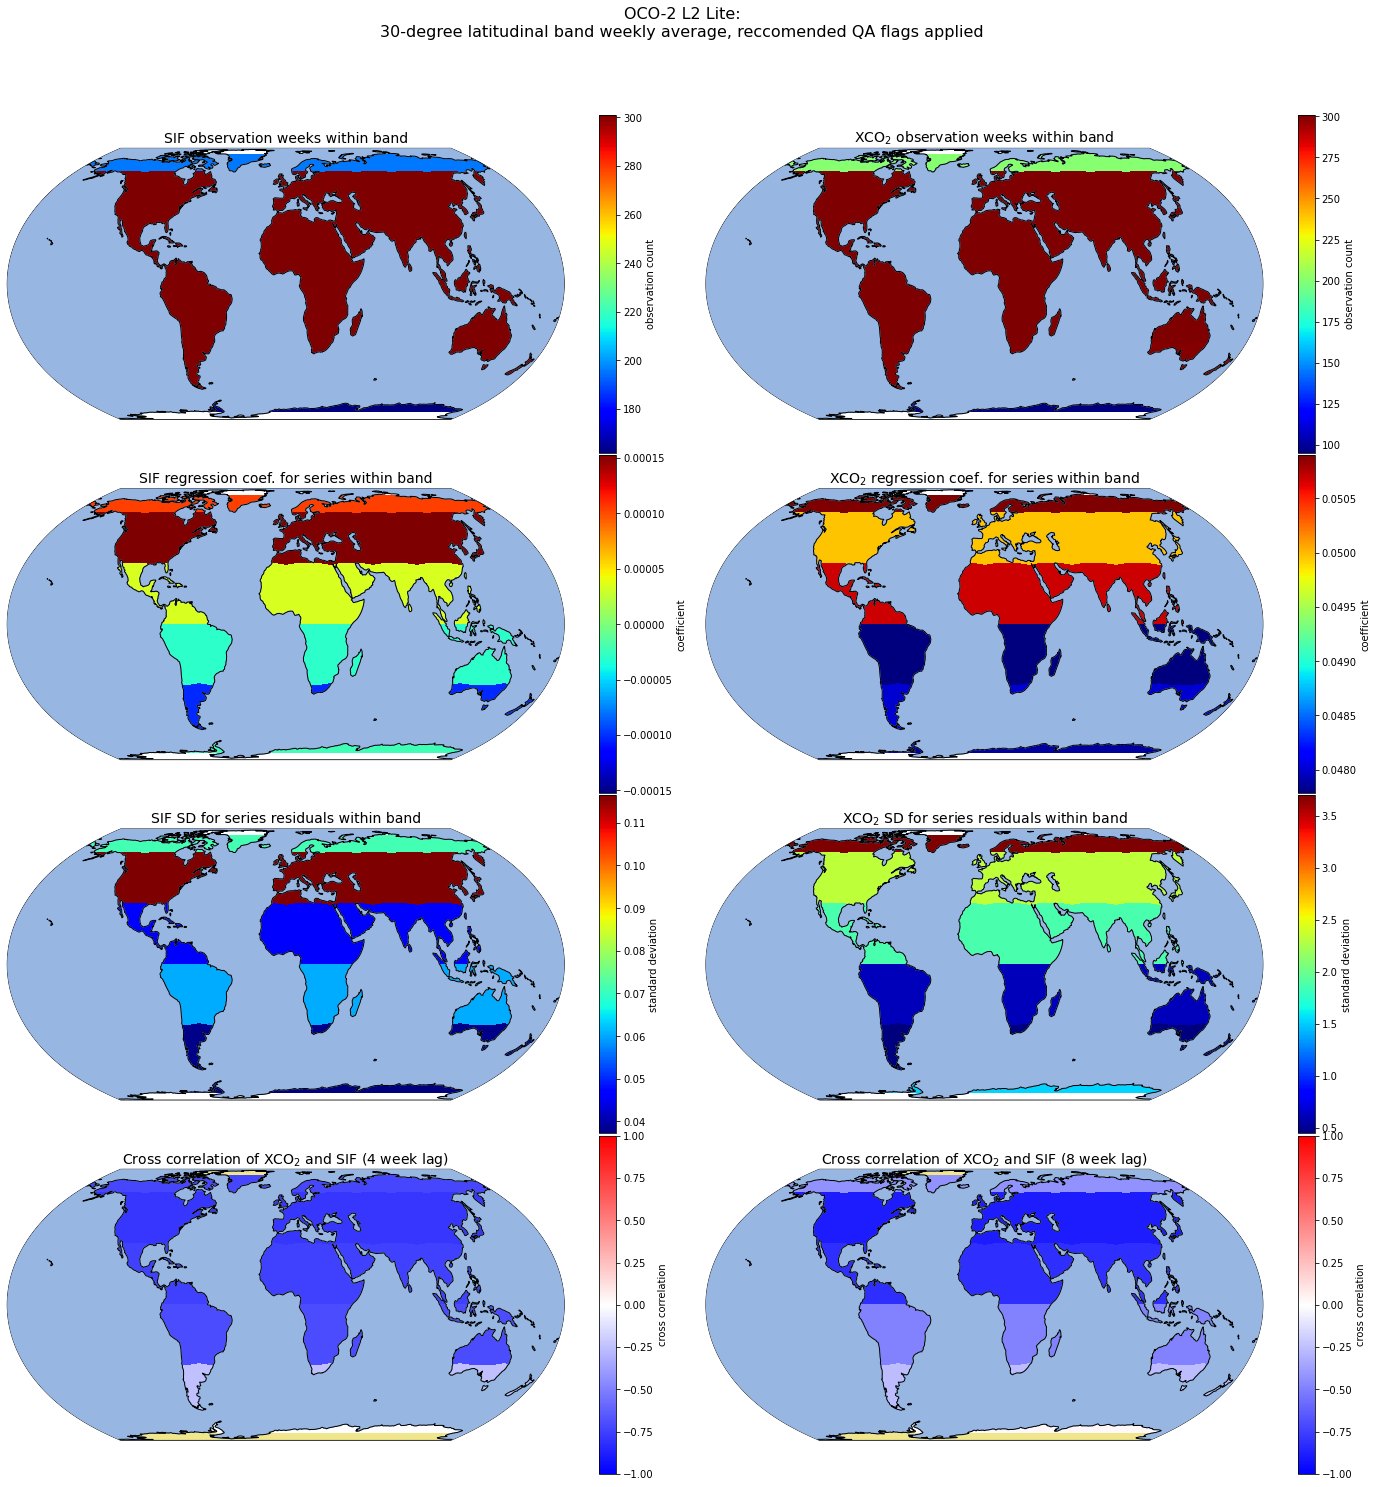

In [6]:
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(100, 100)

# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    "30-degree latitudinal band weekly average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:25, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:25, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.sif_count,
    title="SIF observation weeks within band",
    ax=ax1,
    cbar_kwargs={"label": "observation count"},
    robust=False
)
plot.plot_da(
    DS_grid_weekly.xco2_count,
    title="XCO$_2$ observation weeks within band",
    ax=ax2,
    cbar_kwargs={"label": "observation count"},
    robust=False
)

# Slopes
ax3 = fig.add_subplot(gs[25:50, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[25:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.sif_slope,
    title="SIF regression coef. for series within band",
    ax=ax3,
    cbar_kwargs={"label": "coefficient"}
)
plot.plot_da(
    DS_grid_weekly.xco2_slope,
    title="XCO$_2$ regression coef. for series within band",
    ax=ax4,
    cbar_kwargs={"label": "coefficient"}
)

# Standard deviation
ax5 = fig.add_subplot(gs[50:75, 0:50], projection=ccrs.EqualEarth())
ax6 = fig.add_subplot(gs[50:75, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.sif_std,
    title="SIF SD for series residuals within band",
    ax=ax5,
    cbar_kwargs={"label": "standard deviation"}
)
plot.plot_da(
    DS_grid_weekly.xco2_std,
    title="XCO$_2$ SD for series residuals within band",
    ax=ax6,
    cbar_kwargs={"label": "standard deviation"}
)

# Define color map with nans set to khaki
cmap = plt.get_cmap("bwr")
cmap.set_bad("khaki")

# Cross correlation
ax7 = fig.add_subplot(gs[75:, 0:50], projection=ccrs.EqualEarth())
ax8 = fig.add_subplot(gs[75:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.xcor_lag1,
    title="Cross correlation of XCO$_2$ and SIF (4 week lag)",
    ax=ax7,
    vmin=-1, vmax=1,
    cmap="bwr",
    cbar_kwargs={"label": "cross correlation"}
)
plot.plot_da(
    DS_grid_weekly.xcor_lag2,
    title="Cross correlation of XCO$_2$ and SIF (8 week lag)",
    ax=ax8,
    vmin=-1, vmax=1,
    cmap="bwr",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig("../plots/30deg-band_weekly_panel.png");